In [ ]:
# ================================
# 1️⃣ CÀI ĐẶT THƯ VIỆN CẦN THIẾT
# ================================
!pip install pandas numpy networkx geopy tqdm -q

import os
import pandas as pd
import numpy as np
import networkx as nx
import pickle
from tqdm import tqdm
from geopy.distance import geodesic
from google.colab import files

# ================================
# 2️⃣ TẢI FILE TỪ MÁY LÊN COLAB
# ================================
print("⬆️ Hãy chọn các file GTFS cần tải lên (stops.txt, trips.txt, stop_times.txt, routes.txt, calendar.txt)")
uploaded = files.upload()

# Xác định tên các file đã tải
print("📁 Đã tải lên:", list(uploaded.keys()))

# ================================
# 3️⃣ ĐỌC DỮ LIỆU GTFS
# ================================
stops = pd.read_csv("stops.txt")
trips = pd.read_csv("trips.txt")
stop_times = pd.read_csv("stop_times.txt")

print(f"Stops: {len(stops)}, Trips: {len(trips)}, StopTimes: {len(stop_times)}")

# ================================
# 4️⃣ CHUẨN BỊ DỮ LIỆU
# ================================
stops = stops[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']]
merged = stop_times.merge(trips[['trip_id', 'route_id']], on='trip_id', how='left')
merged = merged.sort_values(['trip_id', 'stop_sequence'])

# ================================
# 5️⃣ XÂY DỰNG ĐỒ THỊ GTFS
# ================================
G = nx.DiGraph()

# Thêm node (các trạm dừng)
for _, row in stops.iterrows():
    G.add_node(row['stop_id'],
               name=row['stop_name'],
               lat=row['stop_lat'],
               lon=row['stop_lon'])

# Hàm tính khoảng cách địa lý giữa hai điểm (m)
def haversine_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

# Thêm cạnh nối các trạm liên tiếp trong cùng trip
for trip_id, group in tqdm(merged.groupby('trip_id'), desc="Building edges"):
    group = group.sort_values('stop_sequence')
    stop_ids = group['stop_id'].values
    for i in range(len(stop_ids)-1):
        s1, s2 = stop_ids[i], stop_ids[i+1]
        if s1 in stops.stop_id.values and s2 in stops.stop_id.values:
            lat1, lon1 = stops.loc[stops.stop_id==s1, ['stop_lat','stop_lon']].values[0]
            lat2, lon2 = stops.loc[stops.stop_id==s2, ['stop_lat','stop_lon']].values[0]
            dist = haversine_distance(lat1, lon1, lat2, lon2)
            if G.has_edge(s1, s2):
                # Nếu cạnh đã tồn tại → lấy cạnh ngắn hơn
                if dist < G[s1][s2]['weight']:
                    G[s1][s2]['weight'] = dist
            else:
                G.add_edge(s1, s2, weight=dist, route_trip=trip_id)

print(f"✅ Đồ thị có {G.number_of_nodes()} nút và {G.number_of_edges()} cạnh")

# ================================
# 6️⃣ LƯU FILE ĐỒ THỊ
# ================================
output_path = "hanoi_gtfs_graph.pkl"
with open(output_path, "wb") as f:
    pickle.dump(G, f)

print("💾 Đã lưu:", output_path)




⬆️ Hãy chọn các file GTFS cần tải lên (stops.txt, trips.txt, stop_times.txt, routes.txt, calendar.txt)


Saving calendar.txt to calendar.txt
Saving routes.txt to routes.txt
Saving stop_times.txt to stop_times.txt
Saving stops.txt to stops.txt
Saving trips.txt to trips.txt
📁 Đã tải lên: ['calendar.txt', 'routes.txt', 'stop_times.txt', 'stops.txt', 'trips.txt']
Stops: 7670, Trips: 6713, StopTimes: 224166


Building edges: 100%|██████████| 6713/6713 [10:35<00:00, 10.56it/s]

✅ Đồ thị có 7670 nút và 7446 cạnh
💾 Đã lưu: hanoi_gtfs_graph.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Cho phép tải file về máy
files.download(output_path)

⬆️ Hãy tải file đồ thị GTFS (.pkl) lên để biểu diễn:


Saving hanoi_gtfs_graph.pkl to hanoi_gtfs_graph.pkl

⏳ Đang tải đồ thị từ 'hanoi_gtfs_graph.pkl'...
✅ Đồ thị đã tải: 7670 nút (trạm), 106683 cạnh (đường đi).

⚠️ Cảnh báo: Đồ thị lớn sẽ tốn thời gian biểu diễn và có thể bị rối.

💾 Đã lưu hình ảnh đồ thị vào file: hanoi_gtfs_graph_full.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

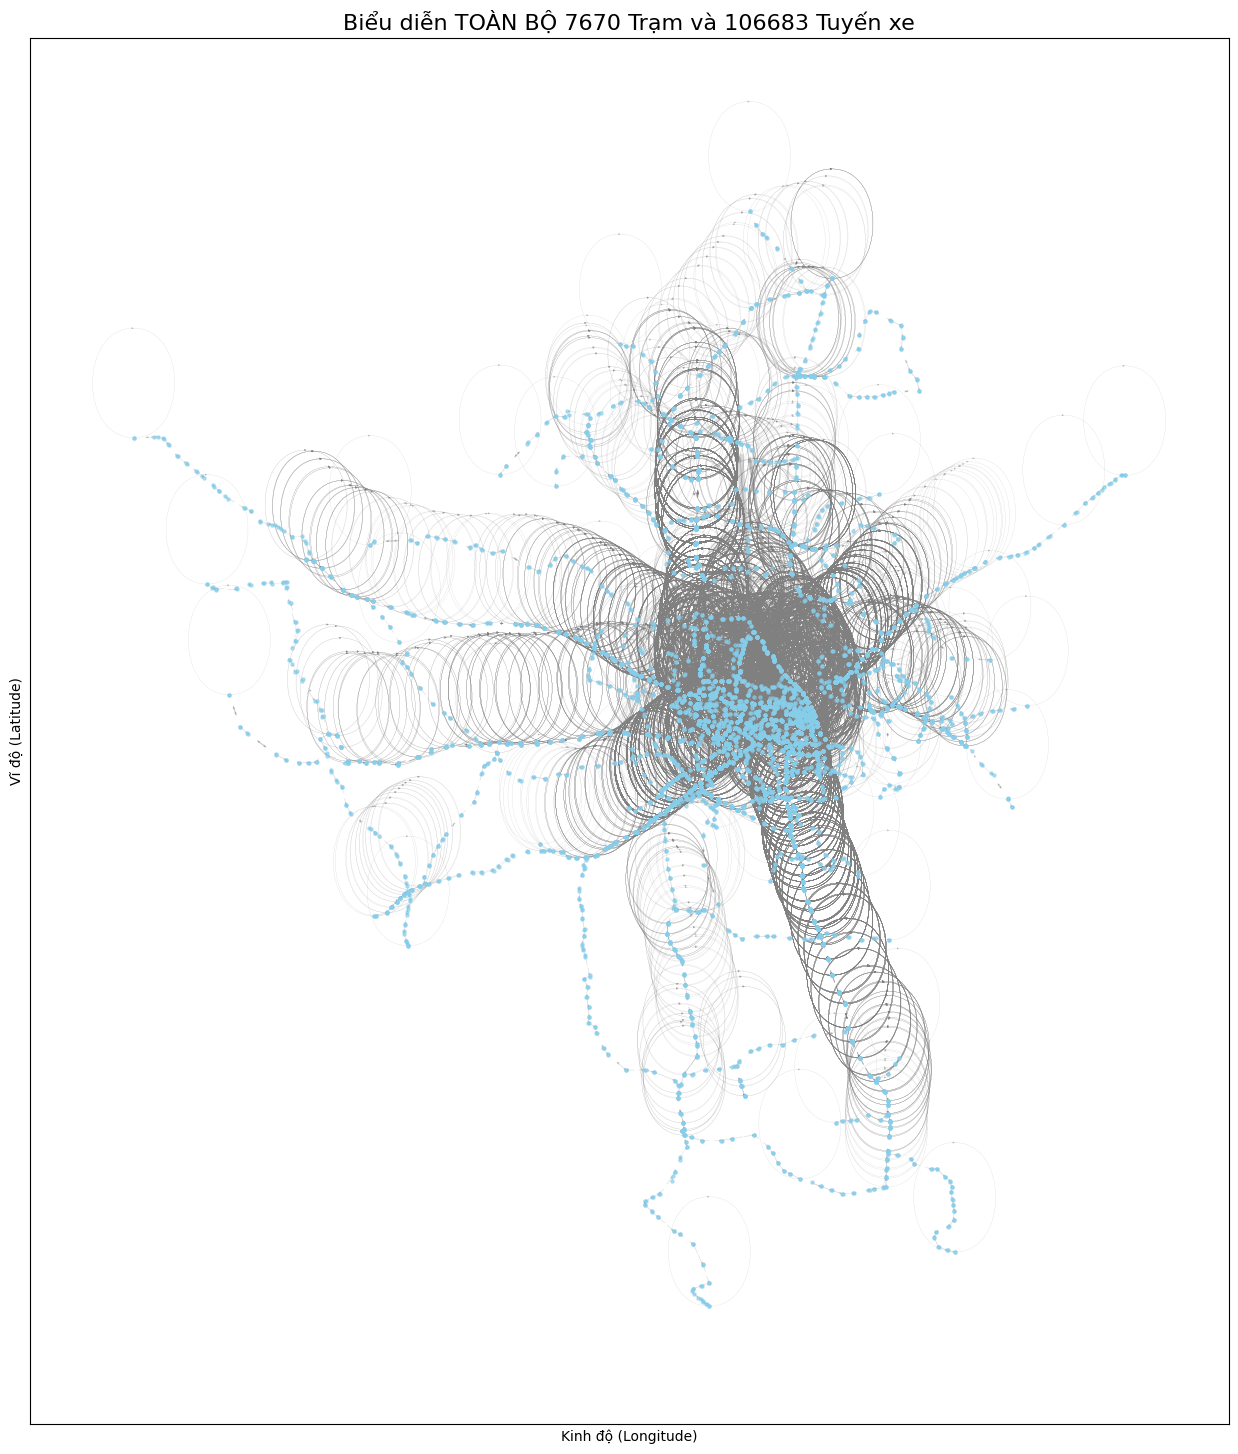

In [ ]:
# =========================================================
# 1️⃣ CÀI ĐẶT THƯ VIỆN & TẢI FILE
# =========================================================
!pip install networkx matplotlib -q

import networkx as nx
import matplotlib.pyplot as plt
import pickle
import os
from google.colab import files
import random
import numpy as np # <--- Đã thêm import numpy

GRAPH_FILE = "hanoi_gtfs_graph.pkl"
OUTPUT_IMAGE_FILE = "hanoi_gtfs_graph_full.png" # Tên file ảnh đầu ra

# Yêu cầu người dùng tải file .pkl lên Colab
print("⬆️ Hãy tải file đồ thị GTFS (.pkl) lên để biểu diễn:")
uploaded = files.upload()

if GRAPH_FILE not in uploaded:
    print(f"❌ Lỗi: Không tìm thấy file '{GRAPH_FILE}'. Vui lòng tải đúng file lên.")
else:
    # =====================================================
    # 2️⃣ TẢI ĐỒ THỊ TỪ FILE
    # =====================================================
    print(f"\n⏳ Đang tải đồ thị từ '{GRAPH_FILE}'...")
    try:
        with open(GRAPH_FILE, "rb") as f:
            G = pickle.load(f)

        print(f"✅ Đồ thị đã tải: {G.number_of_nodes()} nút (trạm), {G.number_of_edges()} cạnh (đường đi).")

        # =====================================================
        # 3️⃣ BIỂU DIỄN TOÀN BỘ ĐỒ THỊ (THEO YÊU CẦU)
        # =====================================================

        H = G # Sử dụng toàn bộ đồ thị G
        print("\n⚠️ Cảnh báo: Đồ thị lớn sẽ tốn thời gian biểu diễn và có thể bị rối.")

        # Lấy vị trí tọa độ (pos) cho các nút
        pos = {node: (data['lon'], data['lat']) for node, data in H.nodes(data=True) if 'lat' in data and 'lon' in data}

        # Lọc lại đồ thị để chỉ giữ các nút có tọa độ
        nodes_to_keep = list(pos.keys())
        H = H.subgraph(nodes_to_keep).copy()

        # =====================================================
        # 4️⃣ VẼ ĐỒ THỊ & LƯU HÌNH ẢNH
        # =====================================================

        # Tùy chỉnh kích thước figure để phù hợp với đồ thị lớn
        plt.figure(figsize=(18, 18))

        # 4.1. Vẽ các nút (trạm dừng)
        nx.draw_networkx_nodes(H, pos,
                               node_size=5, # Giảm kích thước nút
                               node_color='skyblue',
                               alpha=0.6)

        # 4.2. Vẽ các cạnh (đường đi xe buýt)
        edge_weights = [H[u][v].get('weight', 100) / 5000.0 for u, v in H.edges()]

        nx.draw_networkx_edges(H, pos,
                               edge_color='gray',
                               width=np.array(edge_weights) + 0.1,
                               arrowsize=3,
                               alpha=0.3)

        # Thiết lập tiêu đề và hiển thị
        plt.title(f"Biểu diễn TOÀN BỘ {H.number_of_nodes()} Trạm và {H.number_of_edges()} Tuyến xe", fontsize=16)
        plt.xlabel("Kinh độ (Longitude)")
        plt.ylabel("Vĩ độ (Latitude)")
        plt.gca().set_aspect('equal', adjustable='box') # Giữ tỉ lệ bản đồ

        # ----------------------------------------------------
        # THÊM CHỨC NĂNG LƯU VÀ TẢI ẢNH XUỐNG
        # ----------------------------------------------------
        plt.savefig(OUTPUT_IMAGE_FILE, format="png", dpi=300)
        print(f"\n💾 Đã lưu hình ảnh đồ thị vào file: {OUTPUT_IMAGE_FILE}")
        files.download(OUTPUT_IMAGE_FILE)

        plt.show()

    except Exception as e:
        print(f"❌ Đã xảy ra lỗi trong quá trình xử lý đồ thị: {e}")

⬆️ Hãy tải file đồ thị GTFS (.pkl) lên để biểu diễn:


Saving hanoi_gtfs_graph.pkl to hanoi_gtfs_graph.pkl

⏳ Đang tải đồ thị từ 'hanoi_gtfs_graph.pkl'...
✅ Đồ thị đã tải: 7670 nút (trạm), 106683 cạnh (đường đi).

⚠️ Đồ thị lớn. Chỉ biểu diễn 50 nút và các cạnh liên quan.

💾 Đã lưu hình ảnh đồ thị vào file: hanoi_gtfs_graph_sample_50nodes.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

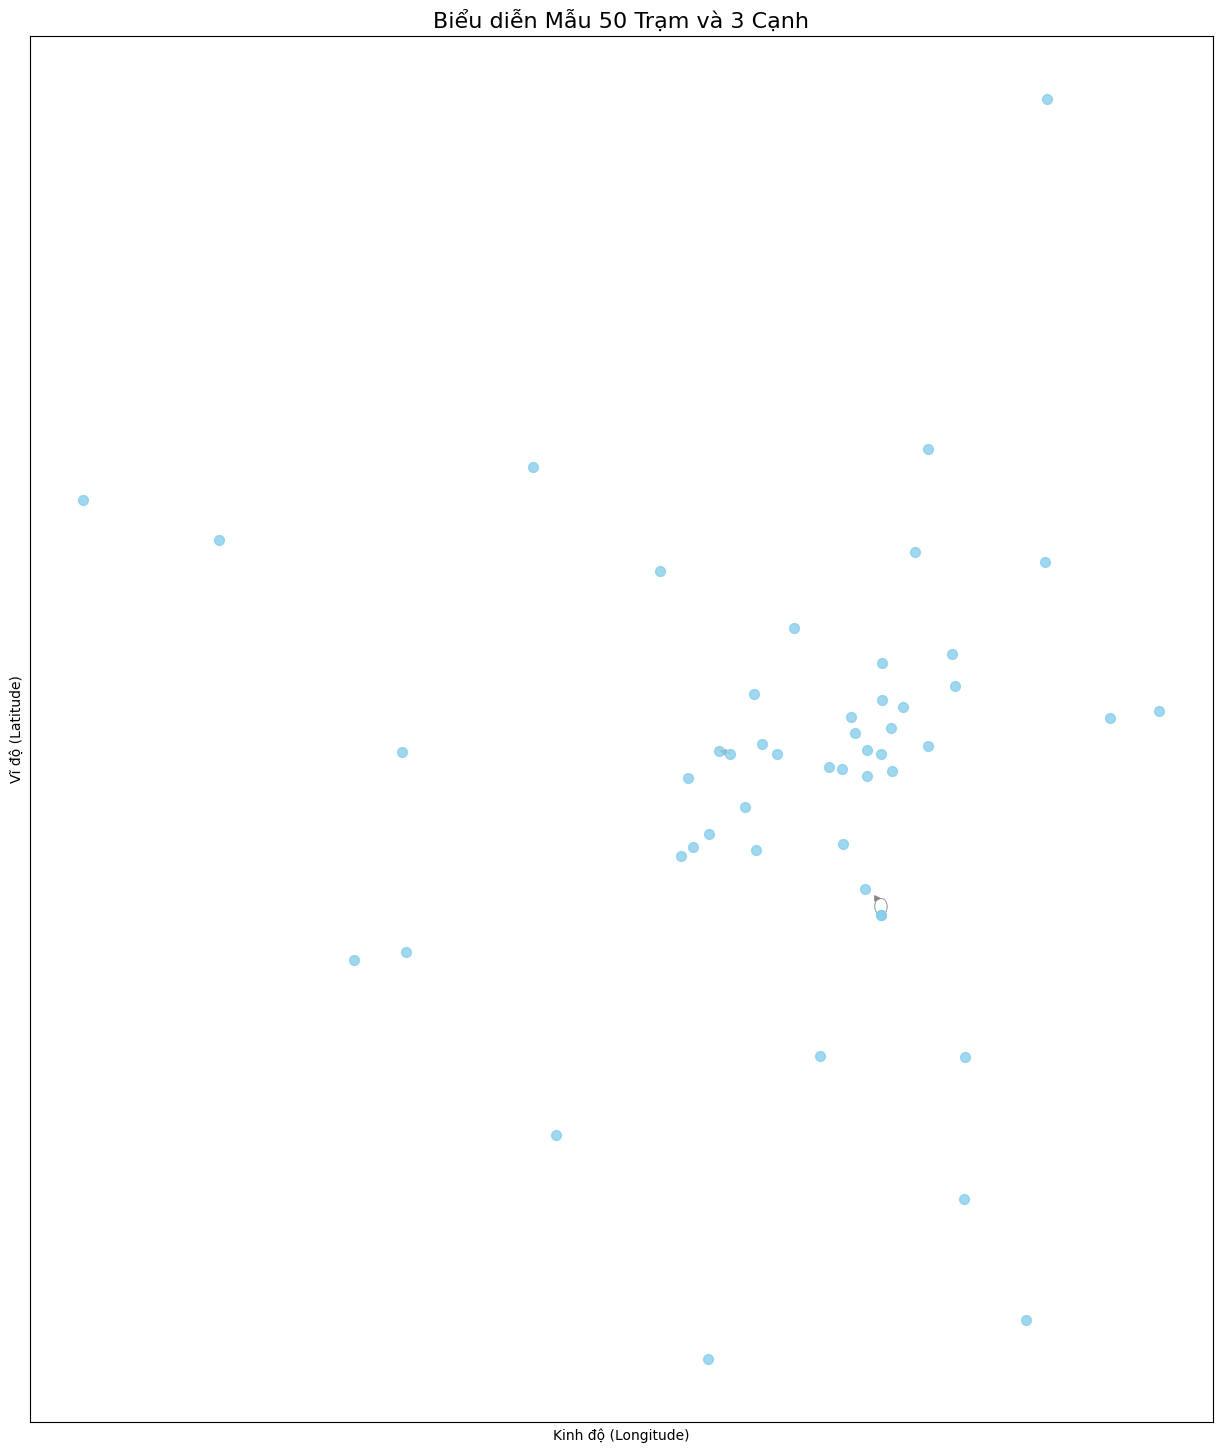

In [ ]:
# =========================================================
# 1️⃣ CÀI ĐẶT THƯ VIỆN & TẢI FILE
# =========================================================
!pip install networkx matplotlib -q

import networkx as nx
import matplotlib.pyplot as plt
import pickle
import os
from google.colab import files
import random
import numpy as np # <--- Đã thêm import numpy

GRAPH_FILE = "hanoi_gtfs_graph.pkl"
OUTPUT_IMAGE_FILE = "hanoi_gtfs_graph_full.png" # Tên file ảnh đầu ra

# Yêu cầu người dùng tải file .pkl lên Colab
print("⬆️ Hãy tải file đồ thị GTFS (.pkl) lên để biểu diễn:")
uploaded = files.upload()

if GRAPH_FILE not in uploaded:
    print(f"❌ Lỗi: Không tìm thấy file '{GRAPH_FILE}'. Vui lòng tải đúng file lên.")
else:
    # =====================================================
    # 2️⃣ TẢI ĐỒ THỊ TỪ FILE
    # =====================================================
    print(f"\n⏳ Đang tải đồ thị từ '{GRAPH_FILE}'...")
    try:
        with open(GRAPH_FILE, "rb") as f:
            G = pickle.load(f)

        print(f"✅ Đồ thị đã tải: {G.number_of_nodes()} nút (trạm), {G.number_of_edges()} cạnh (đường đi).")

        # =====================================================
        # 3️⃣ BIỂU DIỄN MẪU NGẪU NHIÊN 50 NÚT
        # =====================================================

        MAX_NODES_TO_DRAW = 50 # Giới hạn số nút cần vẽ

        nodes_with_coords = [node for node, data in G.nodes(data=True) if 'lat' in data and 'lon' in data]

        if len(nodes_with_coords) > MAX_NODES_TO_DRAW:
            # Chọn ngẫu nhiên 50 nút
            sample_nodes = random.sample(nodes_with_coords, MAX_NODES_TO_DRAW)
            # Tạo đồ thị con chỉ chứa các nút đã chọn và các cạnh giữa chúng
            H = G.subgraph(sample_nodes).copy()
            print(f"\n⚠️ Đồ thị lớn. Chỉ biểu diễn {H.number_of_nodes()} nút và các cạnh liên quan.")
        else:
            H = G
            print(f"\nBiểu diễn toàn bộ {H.number_of_nodes()} nút.")

        # Lấy vị trí tọa độ (pos) cho các nút
        pos = {node: (data['lon'], data['lat']) for node, data in H.nodes(data=True) if 'lat' in data and 'lon' in data}

        # Lọc lại đồ thị để chỉ giữ các nút có tọa độ (cần thiết cho pos)
        nodes_to_keep = list(pos.keys())
        H = H.subgraph(nodes_to_keep).copy()

        # =====================================================
        # 4️⃣ VẼ ĐỒ THỊ & LƯU HÌNH ẢNH
        # =====================================================

        # Tùy chỉnh kích thước figure để phù hợp
        plt.figure(figsize=(18, 18))

        # 4.1. Vẽ các nút (trạm dừng)
        nx.draw_networkx_nodes(H, pos,
                               node_size=50, # Tăng kích thước nút để dễ nhìn hơn trên biểu đồ nhỏ
                               node_color='skyblue',
                               alpha=0.8)

        # 4.2. Vẽ các cạnh (đường đi xe buýt)
        # Chuẩn hóa trọng số (khoảng cách) để kiểm soát độ dày cạnh
        edge_weights = [H[u][v].get('weight', 100) / 5000.0 for u, v in H.edges()]

        nx.draw_networkx_edges(H, pos,
                               edge_color='gray',
                               width=np.array(edge_weights) + 0.5, # Tăng độ dày cạnh
                               arrowsize=10, # Tăng kích thước mũi tên
                               alpha=0.7)

        # Thiết lập tiêu đề và hiển thị
        plt.title(f"Biểu diễn Mẫu {H.number_of_nodes()} Trạm và {H.number_of_edges()} Cạnh", fontsize=16)
        plt.xlabel("Kinh độ (Longitude)")
        plt.ylabel("Vĩ độ (Latitude)")
        plt.gca().set_aspect('equal', adjustable='box') # Giữ tỉ lệ bản đồ

        # ----------------------------------------------------
        # THÊM CHỨC NĂNG LƯU VÀ TẢI ẢNH XUỐNG
        # ----------------------------------------------------
        # Tạo tên file ảnh phù hợp với số lượng nút
        output_name = f"hanoi_gtfs_graph_sample_{H.number_of_nodes()}nodes.png"
        plt.savefig(output_name, format="png", dpi=300)
        print(f"\n💾 Đã lưu hình ảnh đồ thị vào file: {output_name}")
        files.download(output_name)

        plt.show()

    except Exception as e:
        print(f"❌ Đã xảy ra lỗi trong quá trình xử lý đồ thị: {e}")